In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import curve_fit

In [2]:
def estimate_order_arrival_rate(spread_series):
    # Drop missing values and compute spread frequency
    spread_series = spread_series.dropna()
    spread_counts = spread_series.value_counts().sort_index()
    
    spreads = spread_counts.index.values
    frequencies = spread_counts.values
    
    # Normalize to approximate arrival rate (unit-less proxy)
    normalized_arrivals = frequencies / np.sum(frequencies)
    
    # Define the exponential model λ(δ) = A * exp(-k * δ)
    def exp_model(delta, A, k):
        return A * np.exp(-k * delta)
    
    # Fit the model
    popt, _ = curve_fit(exp_model, spreads, normalized_arrivals, p0=(1.0, 1.0))
    
    A, k = popt
    return A, k

In [3]:
def update_volatility(prices):
    lambda_=0.94
    vol_floor=0.0005
    if len(prices) < 2:
        return vol_floor
    log_returns = np.diff(np.log(prices))
    squared_returns = log_returns**2
    weights = (1 - lambda_) * lambda_**np.arange(len(squared_returns))[::-1]
    ewma_vol = np.sqrt(np.sum(weights * squared_returns))
    return max(ewma_vol, vol_floor)

In [4]:
def compute_optimal_quotes(S_t, q, sigma, gamma, T):
    """
    Compute optimal bid and ask quotes using Avellaneda-Stoikov model.
    
    Parameters:
        S_t (float): Current mid-price
        q (float): Current inventory
        sigma (float): Volatility
        A (float): Order arrival rate amplitude
        k (float): Order arrival rate decay
        gamma (float): Risk aversion
        T (float): Time horizon in seconds

    Returns:
        tuple: (optimal_bid, optimal_ask)
    """
    A = 0.2
    k = -0.1
    
    # Reservation price
    r = S_t - q * gamma * sigma**2 * T
    
    # Optimal spread component
    spread_component = gamma * sigma**2 * T / 2 + (1 / gamma) * np.log(1 + gamma / k)
    
    optimal_bid = r - spread_component
    optimal_ask = r + spread_component
    
    return optimal_bid, optimal_ask

In [5]:
def avellaneda_stoikov_reservation_price(price, position, volatility):
    gamma = 0.2  # risk aversion
    spread = 1

    reservation_price = price - position * gamma * volatility**2
    return reservation_price

# Round 1

In [33]:
price_0 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_1/prices_round_1_day_0.csv', delimiter=';')

In [34]:
price_0 = price_0[price_0['product'] == 'SQUID_INK']
price_1 = price_1[price_1['product'] == 'SQUID_INK']
price_2 = price_2[price_2['product'] == 'SQUID_INK']

In [35]:
trades_0 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_1/trades_round_1_day_0.csv', delimiter=';')

In [36]:
trades_0 = trades_0[trades_0['symbol'] == 'SQUID_INK']
trades_1 = trades_1[trades_1['symbol'] == 'SQUID_INK']
trades_2 = trades_2[trades_2['symbol'] == 'SQUID_INK']

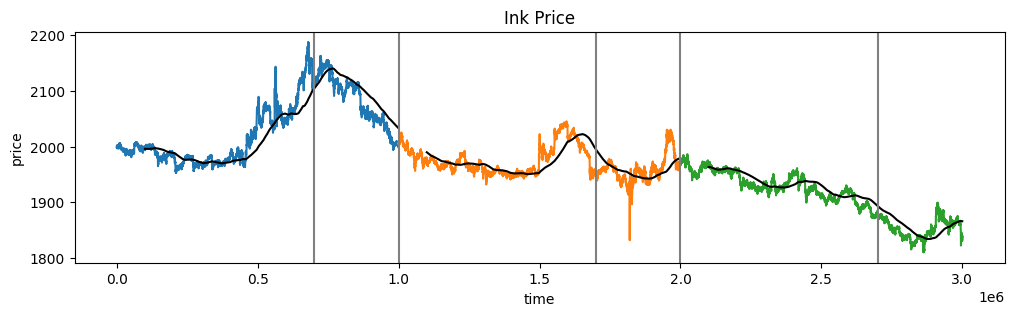

In [8]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_0['timestamp'], price_0['mid_price'].rolling(1000).mean(), c='k')
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'].rolling(1000).mean(), c='k')
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'].rolling(1000).mean(), c='k')
plt.axvline(700000, c='gray')
plt.axvline(1000000, c='gray')
plt.axvline(1700000, c='gray')
plt.axvline(2000000, c='gray')
plt.axvline(2700000, c='gray')
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [9]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [103]:
np.polyfit(np.arange(len(list(prices['filtered_mid_price'].iloc[:100].to_numpy()))), list(prices['filtered_mid_price'].iloc[:100].to_numpy()), deg=1)[0]

np.float64(0.04276627662764311)

In [101]:
np.polyfit(np.arange(100), prices['filtered_mid_price'].iloc[:100].to_numpy(), deg=1)[0]

np.float64(0.04276627662764311)

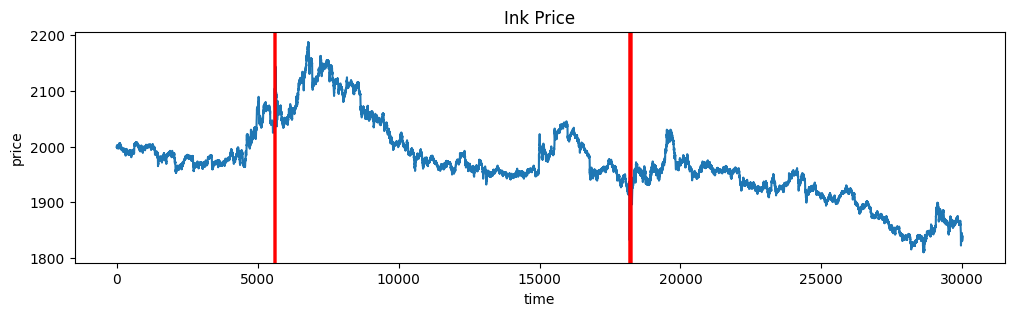

In [92]:
vol = prices['mid_price'].rolling(100).apply(update_volatility)
high_vol_inds = vol[vol > 0.005].index.to_numpy()

plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'])
for ind in high_vol_inds:
    plt.axvline(ind, c='r')
plt.title('Ink Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [12]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [13]:
filtered_mid_prices = []
for i in range(prices.shape[0]):
    price = prices.iloc[i]
    bid_prices = price[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
    bid_volumes = price[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].to_numpy()
    bids = dict(zip(bid_prices, bid_volumes))
    ask_prices = price[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
    ask_volumes = price[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].to_numpy()
    asks = dict(zip(ask_prices, ask_volumes))
    
    filtered_asks = [price for price in asks if abs(asks[price]) >= 15]
    filtered_bids = [price for price in bids if abs(bids[price]) >= 15]
    best_filtered_ask = min(filtered_asks) if len(filtered_asks) > 0 else None
    best_filtered_bid = max(filtered_bids) if len(filtered_bids) > 0 else None

    if best_filtered_ask and best_filtered_bid:
        filtered_mid_price = (best_filtered_ask + best_filtered_bid) / 2
    else:
        filtered_mid_price = price['mid_price']
    filtered_mid_prices.append(filtered_mid_price)
prices = prices.assign(filtered_mid_price=filtered_mid_prices)

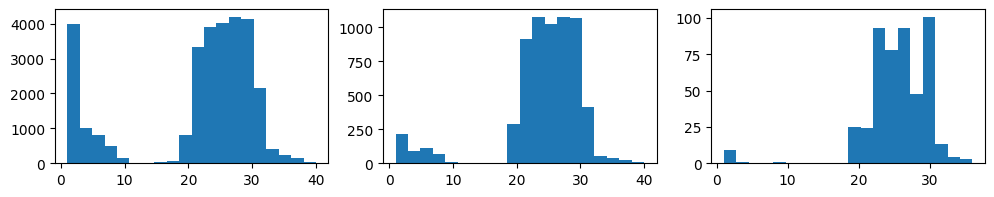

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['bid_volume_1'], bins=20)
ax[1].hist(prices['bid_volume_2'], bins=20)
ax[2].hist(prices['bid_volume_3'], bins=20)
plt.show()

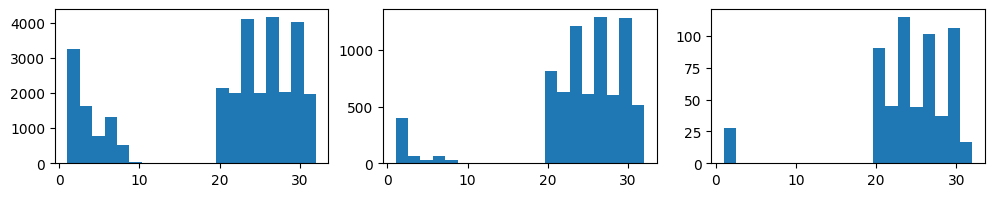

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['ask_volume_1'], bins=20)
ax[1].hist(prices['ask_volume_2'], bins=20)
ax[2].hist(prices['ask_volume_3'], bins=20)
plt.show()

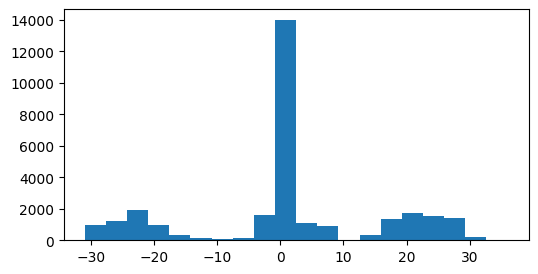

In [16]:
plt.figure(figsize=(6, 3))
plt.hist(prices['bid_volume_1'] - prices['ask_volume_1'], bins=20)
plt.show()

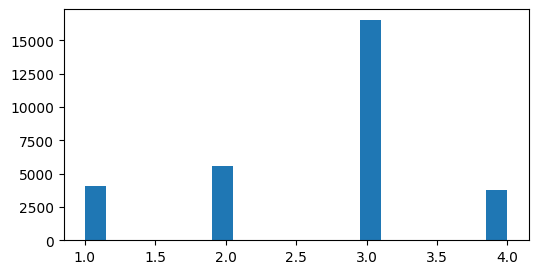

In [17]:
plt.figure(figsize=(6, 3))
plt.hist(prices['ask_price_1'] - prices['bid_price_1'], bins=20)
plt.show()

In [38]:
estimate_order_arrival_rate(prices['ask_price_1'] - prices['bid_price_1'])

(np.float64(0.19646838475951717), np.float64(-0.09502965611894472))

Order arrival rate: λ(δ)=A.exp(−kδ)

In [62]:
list(prices.iloc[:1].iterrows())[0]['bid_price_1']

1998

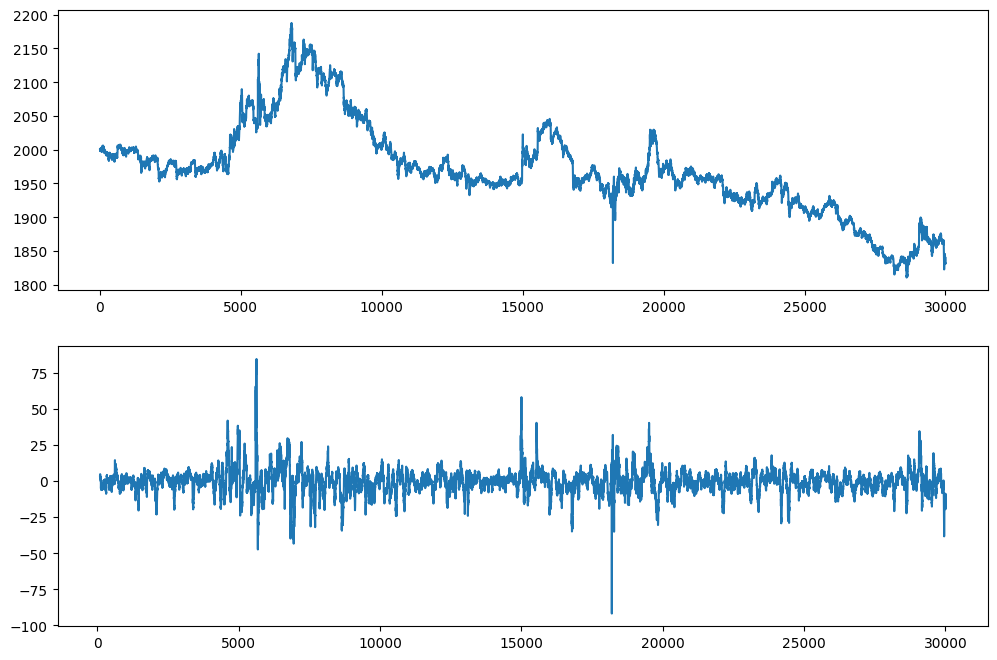

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(prices['pop_mid_price'])
ax[1].plot(prices['pop_mid_price'] - prices['pop_mid_price'].rolling(100).mean())
plt.show()

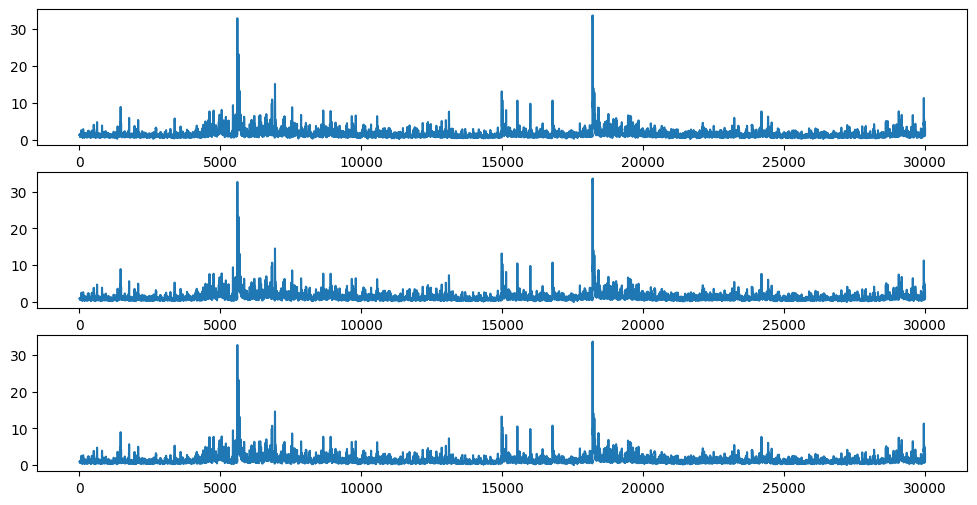

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(prices['mid_price'].rolling(10).std())
ax[1].plot(prices['pop_mid_price'].rolling(10).std())
ax[2].plot(prices['filtered_mid_price'].rolling(10).std())
plt.show()

In [125]:
price = prices.iloc[:100]

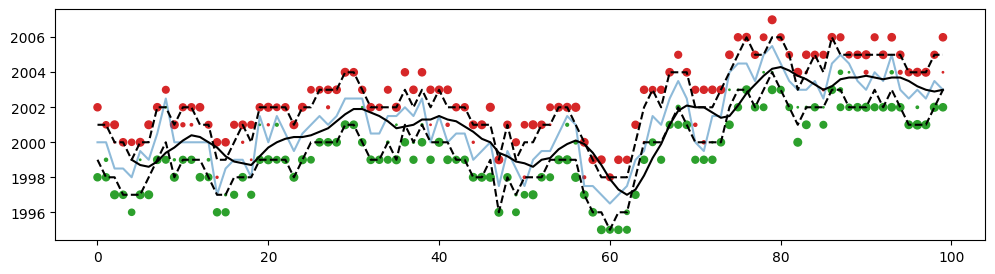

In [247]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['filtered_mid_price'].rolling(5).mean(), c='k')
plt.plot(price['timestamp']//100, np.floor(price['filtered_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['filtered_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

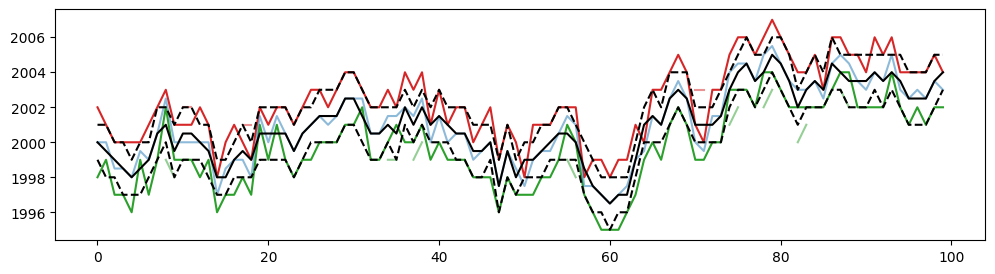

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(price['timestamp']//100, price['bid_price_1'], c='tab:green')
plt.plot(price['timestamp']//100, price['bid_price_2'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['bid_price_3'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_1'], c='tab:red')
plt.plot(price['timestamp']//100, price['ask_price_2'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_3'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['filtered_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['filtered_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['filtered_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

## Analysis

In [78]:
train = prices['filtered_mid_price'].iloc[:prices.shape[0] // 3]
vol = train.rolling(100).apply(update_volatility)
res_train = avellaneda_stoikov_reservation_price(train, 30, vol)

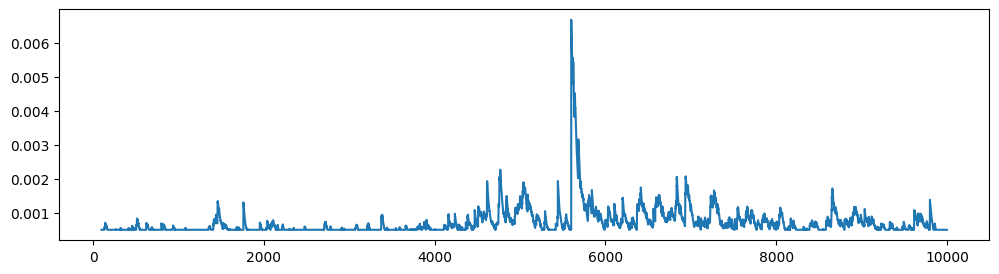

In [79]:
plt.figure(figsize=(12, 3))
plt.plot(vol)
plt.show()

In [23]:
(prices['filtered_mid_price'].iloc[1500:1900] - res_train.iloc[1500:1900]).sum()

np.float64(600.0)

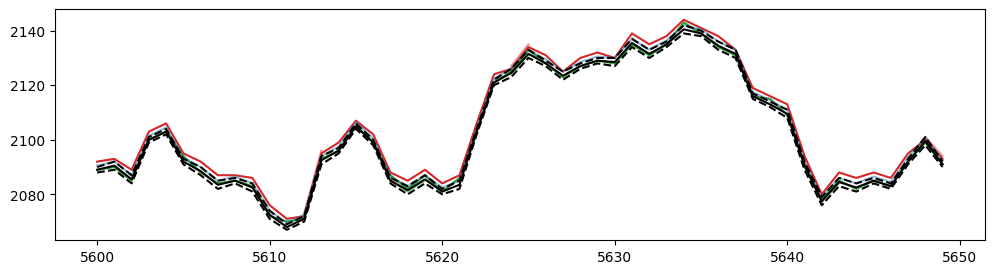

In [24]:
plt.figure(figsize=(12, 3))
plt.plot(prices['bid_price_1'].iloc[5600:5650], c='tab:green')
plt.plot(prices['bid_price_2'].iloc[5600:5650], c='tab:green', alpha=0.5)
plt.plot(prices['bid_price_3'].iloc[5600:5650], c='tab:green', alpha=0.5)
plt.plot(prices['ask_price_1'].iloc[5600:5650], c='tab:red')
plt.plot(prices['ask_price_2'].iloc[5600:5650], c='tab:red', alpha=0.5)
plt.plot(prices['ask_price_3'].iloc[5600:5650], c='tab:red', alpha=0.5)
plt.plot(prices['filtered_mid_price'].iloc[5600:5650], c='tab:blue', alpha=0.5)
plt.plot(res_train.iloc[5600:5650], c='k')
plt.plot(np.floor(res_train.iloc[5600:5650]) - 1, c='k', linestyle='dashed')
plt.plot(np.ceil(res_train.iloc[5600:5650]) + 1, c='k', linestyle='dashed')
plt.show()

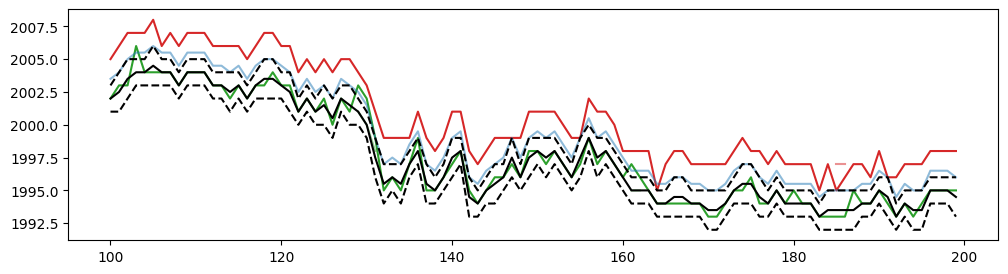

In [25]:
plt.figure(figsize=(12, 3))
plt.plot(prices['bid_price_1'].iloc[100:200], c='tab:green')
plt.plot(prices['bid_price_2'].iloc[100:200], c='tab:green', alpha=0.5)
plt.plot(prices['bid_price_3'].iloc[100:200], c='tab:green', alpha=0.5)
plt.plot(prices['ask_price_1'].iloc[100:200], c='tab:red')
plt.plot(prices['ask_price_2'].iloc[100:200], c='tab:red', alpha=0.5)
plt.plot(prices['ask_price_3'].iloc[100:200], c='tab:red', alpha=0.5)
plt.plot(prices['filtered_mid_price'].iloc[100:200], c='tab:blue', alpha=0.5)
plt.plot(res_train.iloc[100:200], c='k')
plt.plot(np.floor(res_train.iloc[100:200]) - 1, c='k', linestyle='dashed')
plt.plot(np.ceil(res_train.iloc[100:200]) + 1, c='k', linestyle='dashed')
plt.show()

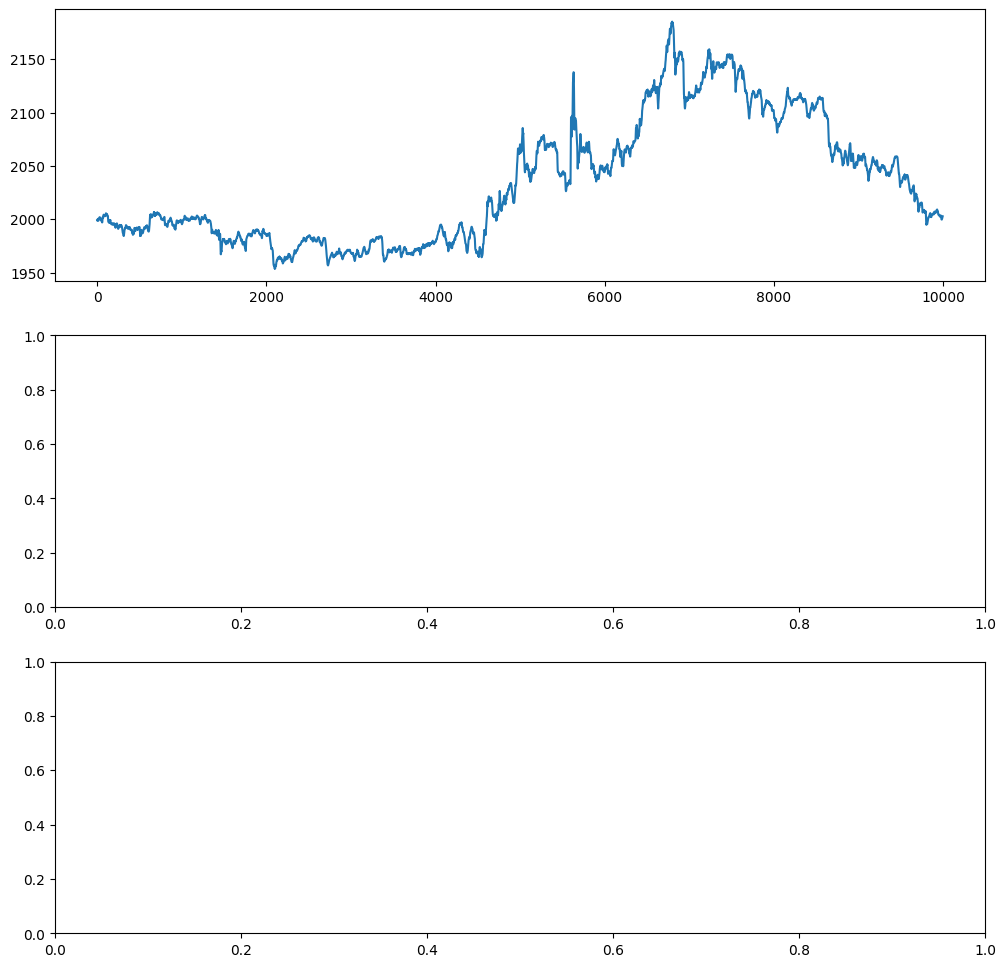

In [228]:
train = prices['filtered_mid_price'].iloc[:prices.shape[0] // 3].rolling(5).mean().dropna().to_numpy()
valid = prices['filtered_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].rolling(5).mean().dropna().to_numpy()
test = prices['filtered_mid_price'].iloc[prices.shape[0] // 3 * 2:].rolling(5).mean().dropna().to_numpy()

# train_roc = (train.shift(100) - train) / train
# valid_roc = (valid.shift(100) - valid) / valid
# test_roc = (test.shift(100) - test) / test

# train_roc = train.rolling(100).apply(lambda x: np.polyfit(np.arange(len(x)), x, deg=1)[0])

# valid_roc = (valid.shift(100) - valid) / valid
# test_roc = (test.shift(100) - test) / test

# train_r = (train.shift(1) / train).dropna()
# train_rr = (train_r.shift(1) / train_r).dropna()
# valid_r = (valid.shift(1) / valid).dropna()
# valid_rr = (valid_r.shift(1) / valid_r).dropna()
# test_r = (test.shift(1) / test).dropna()
# test_rr = (test_r.shift(1) / test_r).dropna()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

# train_logrr = np.log(train_logr.shift(1) / train_logr).dropna()
# valid_logrr = np.log(valid_logr.shift(1) / valid_logr).dropna()
# test_logrr = np.log(test_logr.shift(1) / test_logr).dropna()

# train_vol = train_logr.rolling(10).std().dropna()
# valid_vol = valid_logr.rolling(10).std().dropna()
# test_vol = test_logr.rolling(10).std().dropna()

# train_vol_z = (train_vol - train_vol.rolling(100).mean()) / train_vol.rolling(100).std()

# vol_thr = 1

fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].plot(train)
# ax[0].plot(train.rolling(10).mean())
# ax[0].plot(valid)
# ax[0].plot(test)

# ax[1].plot(train_roc)
# ax[1].axhline(0, c='k')

# ax[1].plot(train - train.rolling(10).mean())
# ax[1].axhline(0, c='k')

# ax[1].plot(valid_roc)
# ax[1].plot(test_roc)
# ax[1].plot(train_r)
# ax[1].plot(valid_r)
# ax[1].plot(test_r)
# ax[2].plot(train_rr)
# ax[2].plot(valid_rr)
# ax[2].plot(test_rr)
# ax[1].plot(train_vol)
# ax[2].plot(train_vol_z)
# ax[2].axhline(vol_thr, c='r')
# ax[2].axhline(-vol_thr, c='r')
# ax[0].set_ylabel('price')
# ax[1].set_ylabel('volatility')
# ax[2].set_ylabel('logr MA')
plt.show()

In [229]:
# plt.figure(figsize=(5, 3))
# plt.hist(train_logr, bins=20, density=True)
# plt.title('Ink Log Returns')
# plt.xlabel('Log Return')
# plt.ylabel('density')
# plt.show()

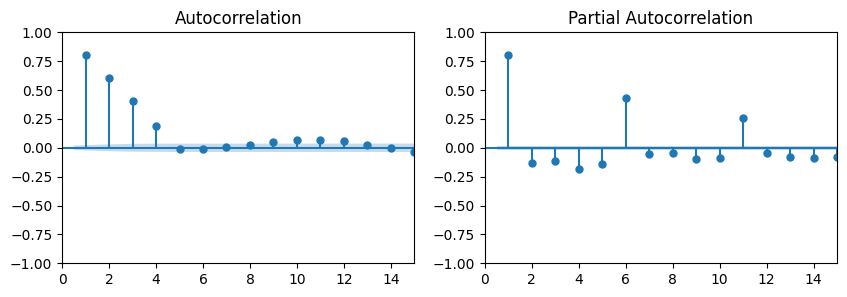

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_logr, ax=ax[0], zero=False)
plot_pacf(train_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

In [233]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# plot_acf(train_rr, ax=ax[0], zero=False)
# plot_pacf(train_rr, ax=ax[1], zero=False)
# ax[0].set_xlim([0, 15])
# ax[1].set_xlim([0, 15])
# plt.show()

## Price prediction - Filtered orders

### Naive

In [234]:
rmse = np.mean(valid_logr ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

y = valid[1:]
y_pred = valid[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0003570206255360921
Price RMSE: 0.6991776774986144


In [235]:
rmse = np.mean(test_logr ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

y = test[1:]
y_pred = test[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00025050021695924535
Price RMSE - test set: 0.4758089922422117


### AR(1)

In [236]:
model = AutoReg(train_logr, lags=1, trend='n')
result = model.fit()

In [237]:
a = result.params[0]
print(f"Estimated AR(1) coefficient: {a}")

Estimated AR(1) coefficient: 0.806094869020332


In [238]:
preds = valid_logr[:-1] * a

In [239]:
pred_price = valid[1:-1] * np.exp(preds)

In [240]:
err = valid_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00026612869924476937
Price RMSE: 0.5184173702139808


In [241]:
preds = test_logr[:-1] * a

In [242]:
pred_price = test[1:-1] * np.exp(preds)

In [243]:
err = test_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

err = test[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00015563257170964548
Price RMSE - test set: 0.2963824824800648


### Cross-validation

In [244]:
np.mean([np.polyfit(train_logr[:-1], train_logr[1:], deg=1)[0],
         np.polyfit(valid_logr[:-1], valid_logr[1:], deg=1)[0],
         np.polyfit(test_logr[:-1], test_logr[1:], deg=1)[0]])

np.float64(0.7563692480225933)

## Volatility prediction

### Naive

In [89]:
err = valid_vol[1:] - valid_vol[:-1]
rmse = np.mean(err ** 2) ** 0.5
print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.00024141496743692234


In [90]:
err = test_vol[1:] - test_vol[:-1]
rmse = np.mean(err ** 2) ** 0.5
print(f'Test RMSE: {rmse}')

Test RMSE: 8.057757314519068e-05


### AR(1)

In [96]:
coeffs = np.polyfit(train_vol[:-1], train_vol[1:], deg=1)
a, b = coeffs

In [97]:
print(a, b)

0.9569647321659633 2.803629954549409e-05


In [98]:
preds = valid_vol[:-1] * a

In [100]:
err = valid_vol[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.00024059356812177902


In [101]:
preds = test_vol[:-1] * a

In [102]:
err = test_vol[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Test RMSE: {rmse}')

Test RMSE: 8.277045104451094e-05


## Price MA prediction

### Naive

In [179]:
err = valid.rolling(10).mean().dropna().to_numpy()[1:] - valid.rolling(10).mean().dropna().to_numpy()[:-1]
rmse = np.mean(err ** 2) ** 0.5
print(f'Validation RMSE: {rmse}')
err = test.rolling(10).mean().dropna().to_numpy()[1:] - test.rolling(10).mean().dropna().to_numpy()[:-1]
rmse = np.mean(err ** 2) ** 0.5
print(f'Test RMSE: {rmse}')

Validation RMSE: 0.4689287196836466
Test RMSE: 0.34897282420273373


### AR(4)

In [186]:
result = AutoReg(train.rolling(10).mean().dropna().to_numpy(), lags=4).fit()

In [187]:
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 9991
Model:                     AutoReg(4)   Log Likelihood                 489.610
Method:               Conditional MLE   S.D. of innovations              0.230
Date:                Sat, 12 Apr 2025   AIC                           -967.219
Time:                        23:41:40   BIC                           -923.965
Sample:                             4   HQIC                          -952.577
                                 9991                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1587      0.081      1.969      0.049       0.001       0.317
y.L1           1.9402      0.010    194.122      0.000       1.921       1.960
y.L2          -0.9331      0.022    -42.746      0.0

In [188]:
result.params

array([ 0.15874997,  1.9402113 , -0.93311774, -0.05550231,  0.04833072])

In [ ]:
preds = valid_vol[:-1] * a

# Round 5

In [7]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'SQUID_INK']
price_1 = price_1[price_1['product'] == 'SQUID_INK']
price_2 = price_2[price_2['product'] == 'SQUID_INK']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'SQUID_INK']
trades_1 = trades_1[trades_1['symbol'] == 'SQUID_INK']
trades_2 = trades_2[trades_2['symbol'] == 'SQUID_INK']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [13]:
bots = list(trades['buyer'].unique())

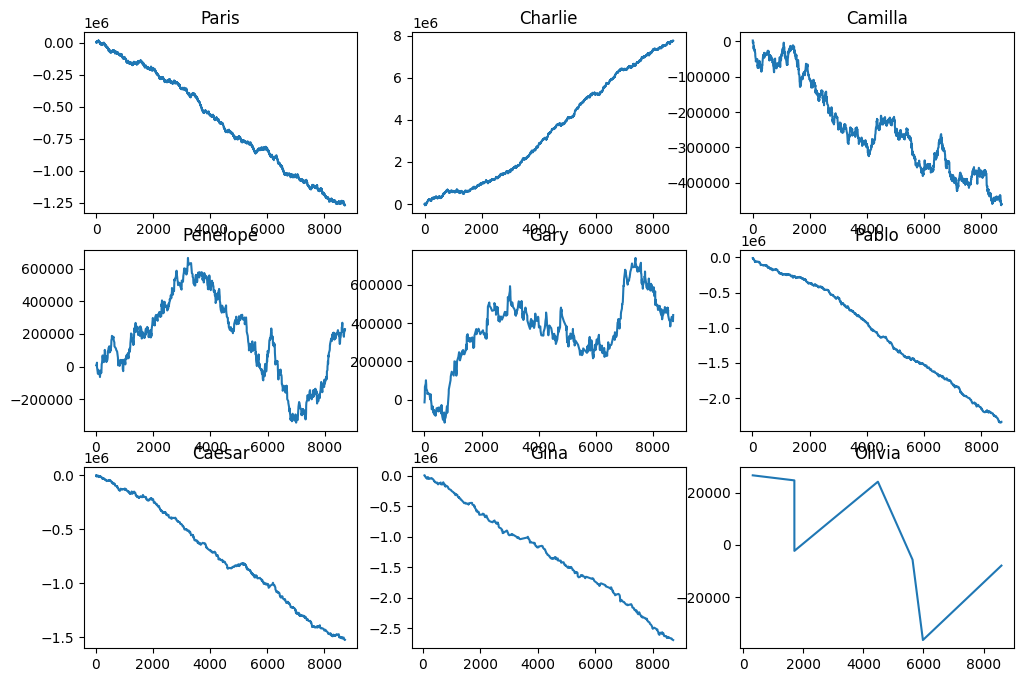

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()